In [1]:
from scipy.interpolate import interp1d
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import re 

# 头文件

class ELEMENT:
    def __init__(self, symbol, name, Z, A, XrayMassCoefTable):
        self.symbol = symbol
        self.name = name
        self.Z = int(Z)
        self.A = float(A) # 元素平均原子量
        self.XrayMassCoefTable = XrayMassCoefTable
        self.Emin = 0.001
        self.Emax = 20
        
        # 根据precision对数据构建插值函数，插值函数的输入为能量，输出为μ/ρ和μen/ρ
        # 插值精度precision代表在Emin~Emax内插值的点数
        self.μ_ρ = interp1d(XrayMassCoefTable['Energy (MeV)'], XrayMassCoefTable['μ/ρ (cm2/g)'], kind='linear')
        self.μen_ρ = interp1d(XrayMassCoefTable['Energy (MeV)'], XrayMassCoefTable['μen/ρ (cm2/g)'], kind='linear')

    def get_μ_ρ(self, energy_lists):
        # 返回能量为energy_lists的μ/ρ
        # 验证energy_lists的范围，只接受self.Emin~self.EmaxMeV的能量
        if not all(self.Emin <= energy <= self.Emax for energy in energy_lists):
             raise ValueError(f"Your input is {min(energy_lists)} ~ {max(energy_lists)} \n energy_lists must be in {self.Emin}~{self.Emax} MeV")
        return self.μ_ρ(energy_lists)
    
    def get_μen_ρ(self, energy_lists):
        # 返回能量为energy_lists的μen/ρ
        # 验证energy_lists的范围，只接受self.Emin~self.EmaxMeV的能量
        if not all(self.Emin <= energy <= self.Emax for energy in energy_lists):
            raise ValueError(f"Your input is {energy_lists} \n energy_lists must be in self.Emin~self.Emax MeV")
        return self.μen_ρ(energy_lists)
    
    def draw(self, precision = 1000):
        # 绘制μ/ρ
        sns.set_style("whitegrid")
        # plt.style.use('seaborn-whitegrid')  # 设置科学绘图风格
        energy_lists = np.logspace(np.log10(self.Emin), np.log10(self.Emax), precision)
        energy_lists = np.clip(energy_lists, self.Emin, self.Emax)  # 限制能量范围在self.Emin~self.EmaxMeV
        # print(energy_lists)
        plt.loglog(energy_lists, self.get_μ_ρ(energy_lists),energy_lists, self.get_μen_ρ(energy_lists))  # 设置双对数坐标
        plt.xlim(self.Emin, self.Emax)
        plt.title(f"{self.Z}, {self.symbol}, {self.name},  μ/ρ and μen/ρ")
        plt.legend(['μ/ρ (cm2/g)', 'μen/ρ (cm2/g)'])
        plt.xlabel("Photon Energy (MeV)")
        plt.ylabel("μ/ρ and μen/ρ (cm2/g)")
        plt.grid(True, which="both", ls="--")  # 添加虚线网格
        plt.show()
        
    def __str__(self):
        return f"{self.symbol} {self.name} {self.Z}"
    
    def __repr__(self):
        return f"{self.symbol} {self.name} {self.Z}"
    
    def __eq__(self, other):
        return self.Z == other.Z
    
    def __lt__(self, other):
        return self.Z < other.Z
    
    def __gt__(self, other):
        return self.Z > other.Z
    
    def __le__(self, other):
        return self.Z <= other.Z
    
    def __ge__(self, other):
        return self.Z >= other.Z
    
    def __ne__(self, other):
        return self.Z != other.Z
    


class ELEMENTS:
    def __init__(self):
        self.elements = {}

    def add(self, element):
        self.elements[element.Z] = element

    def get(self, Z=None, symbol=None, name=None):
        if Z is not None:
            return self.elements[int(Z)]
        for element in self.elements.values():
            if symbol is not None and element.symbol == symbol:
                return element
            if name is not None and element.name == name:
                return element
        return None

    def print_all_elements(self):
        for element in self.elements.values():
            print(f"Symbol: {element.symbol}, Name: {element.name}, Z: {element.Z}")

    def get_ele_ratio(self, chemical):
        pattern = r'([A-Z][a-z]*)(\d*\.?\d*)'
        ele_ratio = []
        for element, ratio in re.findall(pattern, chemical):
            if not ratio:
                ratio = '1'
            ele_ratio.append((element, ratio))
        return ele_ratio

    def get_mass_ratio(self, ele_ratio):
        mole_mass = 0
        mass_ratio = []
        for ele, ratio in ele_ratio:
            mole_mass += self.get(symbol = ele).A * float(ratio)
        mass_ratio = [self.get(symbol = ele).A * float(ratio) / mole_mass for ele, ratio in ele_ratio]
        return mass_ratio

    def get_compound_u_p(self, chemical, energy_lists):
        ele_ratio = self.get_ele_ratio(chemical)
        mass_ratio = self.get_mass_ratio(ele_ratio)
        μ_ρ = 0
        for i in range(len(ele_ratio)):
            μ_ρ += self.get(symbol = ele_ratio[i][0]).get_μ_ρ(energy_lists) * mass_ratio[i]
        return μ_ρ

    def calc_transmission(self, chemical, energy_lists, density, thickness):
        μ_ρ = self.get_compound_u_p(chemical, energy_lists)
        return np.exp(-μ_ρ * density * thickness)*100 # 转换成百分比

    def draw_transmission(self, chemical, energy_lists, density, thickness, img_path=None):
        sns.set_style("whitegrid")  # Set the seaborn style to whitegrid
        plt.plot(energy_lists, self.calc_transmission(chemical, energy_lists, density, thickness)) 
        plt.title(f"{chemical}, {density} g/cm3, {thickness} cm")
        plt.legend(['Transmission (%)'])
        plt.xlabel("Photon Energy (MeV)")
        plt.ylabel("Transmission (%)")
        plt.grid(True, which="both", ls="--")  # 添加虚线网格

        if img_path is None:
            plt.show()
        else:
            print(f"Saving image to {img_path}")
            plt.savefig(img_path, dpi=120)
            plt.close()


# 读取数据

XrayMassCoef_csv_lists = r"./Data/XrayMassCoef_csv_lists/"
elements = ELEMENTS()
for element in os.listdir(XrayMassCoef_csv_lists):
    symbol, name, Z, A, _ = [par.strip() for par in element.split('_')]
    elements.add(ELEMENT(symbol, name, Z, A, pd.read_csv(XrayMassCoef_csv_lists+"/"+element)))

lead = elements.get(name='Lead')

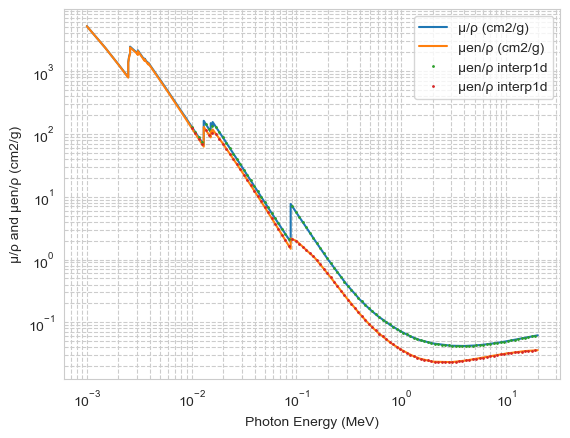

In [12]:
from numpy import log10 as log10
precision = 100

x = lead.XrayMassCoefTable['Energy (MeV)']
y1 = lead.XrayMassCoefTable['μ/ρ (cm2/g)']
y2 = lead.XrayMassCoefTable['μen/ρ (cm2/g)']

sns.set_style("whitegrid")

μ_ρ = interp1d(log10(x), log10(y1), kind='linear')
μen_ρ = interp1d(log10(x), log10(y2), kind='linear')
energy_lists = np.linspace(np.log10(0.01), log10(19.), precision)
# energy_lists = x

# plt.xlim(log10(0.01), log10(20))

# 设置曲线的样式，分别是线，线，点，点
# 设置点的大小为0.5
plt.rcParams['lines.markersize'] = 2
# plt.plot(log10(x), log10(y1), '-', log10(x), log10(y2), '-', energy_lists, μ_ρ(energy_lists), '.', energy_lists, μen_ρ(energy_lists), '.')
plt.loglog(x, y1, '-', x, y2, '-', 10**energy_lists, 10**μ_ρ(energy_lists), '.', 10**energy_lists, 10**μen_ρ(energy_lists), '.')

plt.legend(['μ/ρ (cm2/g)', 'μen/ρ (cm2/g)', 'μen/ρ interp1d', 'μen/ρ interp1d'])

plt.xlabel("Photon Energy (MeV)")
plt.ylabel("μ/ρ and μen/ρ (cm2/g)")
plt.grid(True, which="both", ls="--")  # 添加虚线网格

# 提高画图精度dpi = 300
# plt.savefig("test_precision=-1.png", dpi=400)
plt.show()
